# Iris Data Set

İris çiçeği veri kümesi veya Fisher'ın iris veri kümesi, İngiliz istatistikçi ve biyolog Ronald Fisher tarafından tanıtılan çok değişkenli bir veri kümesidir. Veri seti, üç  iris türünün(Iris setosa, Iris virginica ve Iris versicolor) her birinden 50 örnekten oluşur. Her numuneden dört özellik ölçülür: Taç ve çanak yapraklarının uzunluğu ve genişliği(cm cinsinden)
Bu dört özelliğin kombinasyonuna dayanarak, Fisher türleri birbirinden ayırmak için doğrusal bir diskrimant model geliştirdi.

Bu veri kümesinin dör sütun içeridiği anlamına gelir. Sepal uzunluk, sepal genişlik, petal uzunluk ve petal genişlik. 



In [4]:
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


Veri seti aşağıdaki gibidir.

In [24]:
url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names=["sepal_uzunlugu","sepal_genisligi","petal_uzunlugu","petal_genisligi","sinif"]
dataset = read_csv(url, names=names)
dataset

,sepal_uzunlugu,sepal_genisligi,petal_uzunlugu,petal_genisligi,sinif
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## Problem:
Yeni bir çiçeğin sepal ve petal yaprak uzunluk ve genişliklerini girerek, hangi sınıfa ait olduğunu tahmin etmektir.
#### Kullanılacak Modeller
* Lojistik regresyon
* Karar ağaçları
* En yakın K Komşuluğu
* Lineer diskriminant analizi
* Gauss Naive Bayes algoritması


In [7]:
print(dataset.shape) # Veri boyutu

(150, 5)


In [9]:
# Tanımlayıcı istatistikler

print(dataset.describe())  

       sepal_uzunlugu  sepal_genisligi  petal_uzunlugu  petal_genisligi
count      150.000000       150.000000      150.000000       150.000000
mean         5.843333         3.054000        3.758667         1.198667
std          0.828066         0.433594        1.764420         0.763161
min          4.300000         2.000000        1.000000         0.100000
25%          5.100000         2.800000        1.600000         0.300000
50%          5.800000         3.000000        4.350000         1.300000
75%          6.400000         3.300000        5.100000         1.800000
max          7.900000         4.400000        6.900000         2.500000


In [10]:
# Sınıf dağılımı

print(dataset.groupby("sinif").size())

sinif
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


Not: Veriler hakkında temel bir bilgimiz oldu. Bunu bazı görselleştirmelerle genişletmeliyiz.

İki tür grafik söz konusudur.

   1- Her bir özelliği daha iyi anlamak için tek değişkenli grafikler
   
   2- Nitelikler arasındaki ilişkileri daha iyi anlamak için ise çok değişkenli grafikler

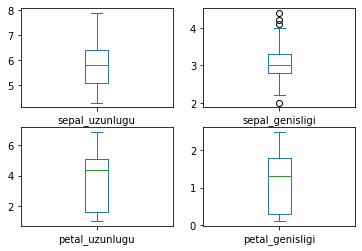

In [11]:
# box and whisker grafikleri
dataset.plot(kind="box", subplots=True, layout=(2,2), sharex=False, sharey=False)
pyplot.show()

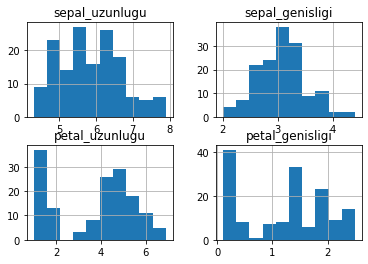

In [12]:
#Histogramlar
dataset.hist()
pyplot.show()

Yorum: Petal genişliği ve uzunluğunun normallikten uzak, sepal uzunluğu ve genişliğinin ise normale daha yakın olduğunu söyleyebiliriz.

Şimdi de değişkenler arasındaki etkileşime bakalım.

İlk olarak, tüm özellik çiftlerinin scatterplot'ına bakalım. Bu öznitelikler arasındaki yapılandırılmış ilişkileri tespit etmek için yararlı olabilir.

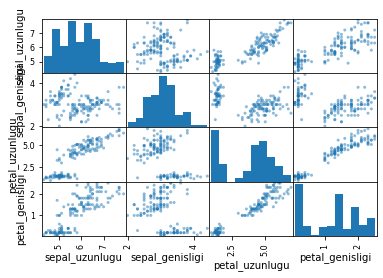

In [13]:
# çok degiskenli serpme matrisi grafigi
scatter_matrix(dataset)
pyplot.show()

Bazı özniteliklerin köşegen gruplandırmasına dikkat etmek gerekir. Bu, yüksek bir korelasyon ve öngörülebilir bir ilişki olduğunu göstermektedir.

Yorum: Serpme grafiğinde eğer noktalar çok dağınıksa doğrusal ilişki olmadığını gösterir. Ancak noktalar üzerinden bir doğru çizdiğimiz zaman doğrunun etrafında toplu ise doğrusal ilişki vardır diyebiliriz. O halde yukarıda 4 yerde doğrusal ilişki olduğunu söyleyebiliriz.

Bazı veri modelleri oluşturmanın ve görünmeyen verilerdeki doğruluğunu tahmin etmeye başlayalım.

1- Bir doğrulama veri kümesini ayıralım.

2- Test için, 10 kat çapraz doğrulama(farklı da kullanabiliriz) kullanacak şekile ayarlayalım.

3- Çiçek ölçümlerinin türleri tahmin etmek için birden fazla farklı model oluşturalım.

4- En iyi modeli seçelim.

1- Oluşturulan modelin iyi olduğunu bilmemiz gerekiyor. Daha sonra görünmeyen veriler üzerinde oluşturduğumuz modellerin doğruluğunu tahmin etmek için istatistiksel yöntemler kullanalım.

In [14]:
# Veri setin ayırma
# %80'i modelleri arasında eğitmek,değerlendirmek,seçmek için,
# %20'si bir doğrulama veri kümesi oluşturmak için
array = dataset.values
x = array[:,0:4]  #öznitelik değişkeni
y = array[:,4]    # hedef değişken
X_egitim, X_validasyon, Y_egitim, Y_validasyon = train_test_split(x,y,test_size=0.20, random_state=1)
# random_state'i rastgelelik için kullandık

2- Model doğruluğunu tahmin etmek için tabakalı 10 kat çapraz doğrulama kullanalım. Bu da veri kümemizi 10 parçaya bölecek, 9 parça ile veri eğitilecek ve kalan 1 parça ile test  edecek ve eğitim-test bölünmelerinin tüm kombinasyonları için tekrar edecektir.


3- Algoritmaları(6 farklı) test edelim.

In [15]:
# Algoritmalar
models=[]
models.append(("LR",LogisticRegression(solver="liblinear",multi_class="ovr")))
models.append(("LDA",LinearDiscriminantAnalysis())) # Doğrusal Diskriminant Analizi
models.append(("KNN",KNeighborsClassifier()))       # En Yakın K Komşuluğu
models.append(("CART", DecisionTreeClassifier()))   # Sınıflandırma ve Regresyon Ağaçları
models.append(("NB",GaussianNB()))                  # Gauss Naive Bayes
models.append(("SVM", SVC(gamma="auto")))           # Destek Vektör Makineleri

In [16]:
# Model Metriklerini Hesaplama
sonuclar=[]
names=[]
for name, model in models:
    kfold=StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_sonuclar=cross_val_score(model,X_egitim, Y_egitim, cv=kfold, scoring="accuracy")
    sonuclar.append(cv_sonuclar)
    names.append(name)
    print("%s:%f(%f)"%(name,cv_sonuclar.mean(),cv_sonuclar.std()))

LR:0.941667(0.065085)
LDA:0.975000(0.038188)
KNN:0.958333(0.041667)
CART:0.958333(0.041667)
NB:0.950000(0.055277)
SVM:0.983333(0.033333)


4- Modelleri birbiri ile karşılaştırı en doğru olanı seçmeliyiz.
Yorum: Algoritmanın veya değerlendirme prosedürrünün stokastik durumu veya sayısal doğruluktaki farklılıklar göz önüne alındığında değişebilir. Örneğin birkaç kez çalıştırıp ve ortalama sonuçları ona göre karşılaştırabiliriz.
 SVM  yaklaşık 0.98 olarak en büyük tahmini doğruluğa sahiptir.
 


 Her algoritma için sonuç örneklerini karşılaştırmanın yararlı bir yolu, her dağıtım için aşlağıdaki gibi bir kutu grafiği oluşturmak ve dağılımları karşılaştırmaktır.

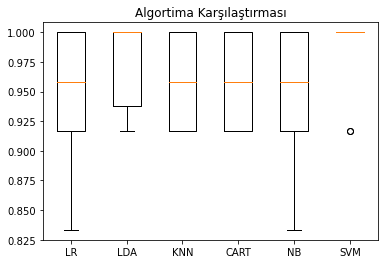

In [17]:
# Algoritmalari Karsilastirma
pyplot.boxplot(sonuclar, labels=names)
pyplot.title("Algortima Karşılaştırması")
pyplot.show()

Önceki bölümlerde SVM'nin en doğru model olduğunu göstermekte idi. Bu modeli son model olarak kullanalım.

In [20]:
# Tahminler Yapma
model = SVC(gamma="auto")
model.fit(X_egitim, Y_egitim)
tahminler = model.predict(X_validasyon)

In [21]:
# Model Doğruluğu
print(accuracy_score(Y_validasyon, tahminler))
print(confusion_matrix(Y_validasyon, tahminler))
print(classification_report(Y_validasyon, tahminler))

0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



Yorum: Doğruluk 0.966'dır. Karışıklık matrisi(confusion_matrix), yapılan hataların bir göstergesini sağlar.
Sınıflandırma raporu, hassasiyet, gerçek pozitif oranı, f1 skoru ve destek değerleri için mükemmele yakın değerler sağlar.